In [1]:
# Cài đặt nếu chưa có
# !pip install pandas matplotlib seaborn wordcloud

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rapidfuzz.fuzz import token_set_ratio
from underthesea import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from tqdm.auto import tqdm
tqdm.pandas() # Kích hoạt progress bar cho pandas

# Cài đặt font chữ hỗ trợ Tiếng Việt cho Matplotlib
plt.rcParams['font.family'] = 'DejaVu Sans'

print("Các thư viện đã được import thành công!")


Các thư viện đã được import thành công!


In [2]:
# Đường dẫn tới file dữ liệu
DATA_PATH = '/home/guest/Projects/DSC2025/BAN/vihallu-train.csv' # Thay 'train_set.csv' bằng tên file training thực tế của bạn

# Đọc dữ liệu
try:
    df = pd.read_csv(DATA_PATH)
    print(f"Đọc thành công {len(df)} mẫu dữ liệu từ '{DATA_PATH}'")
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file tại '{DATA_PATH}'. Vui lòng kiểm tra lại đường dẫn.")
    df = None

if df is not None:
    # In ra 5 dòng đầu tiên
    print("\n5 dòng dữ liệu đầu tiên:")
    display(df.head())

    # In thông tin tổng quan (số lượng non-null, kiểu dữ liệu)
    print("\nThông tin chung về DataFrame:")
    df.info()

    # Kiểm tra xem có giá trị null nào không
    print("\nKiểm tra giá trị bị thiếu (null):")
    print(df.isnull().sum())


Đọc thành công 7000 mẫu dữ liệu từ '/home/guest/Projects/DSC2025/BAN/vihallu-train.csv'

5 dòng dữ liệu đầu tiên:


,id,context,prompt,response,label
0,9b1ea51d-d1ff-45ba-8cf1-6a91328e8600,"Vào những năm 1870, hai nhà điêu khắc Augustus...","Vào những năm 1960, nơi nào trở thành trung tâ...",Quảng trường Washington là trung tâm của thế h...,extrinsic
1,db7a89c6-2a6a-42af-beef-58e557ecc819,Cách mạng Tháng Mười đã biến một cuộc chiến tr...,Cách mạng Tháng Mười đã khởi xướng chủ nghĩa p...,Sai. Cách mạng Tháng Mười đã đánh bại chủ nghĩ...,no
2,10fca062-d343-4eca-8434-93c7a8aa5e0e,Vị trí địa lý nằm giữa phương Đông và Địa Trun...,Dựa trên việc Đế quốc Ottoman không bao giờ ki...,Nền ẩm thực của Thổ Nhĩ Kỳ được xây dựng từ gi...,extrinsic
3,ece8eb9e-d6bb-407a-a567-d9531861c603,"Hồ Quý Ly trước có tên là Lê Quý Ly (黎季犛), biể...",Đời cháu thứ 12 của Hồ Hưng Dật sống ở đâu?,"Đời cháu thứ 12 của Hồ Hưng Dật, là Hồ Liêm, s...",no
4,b613217f-df2a-491e-8326-25811a31eb09,"Năm 2007, Bồ Đào Nha có khoảng 332.137 người n...","Từ thập niên 1990, tại sao xuất hiện một vài l...",Mặc dù Bồ Đào Nha đã đóng cửa biên giới hoàn t...,intrinsic



Thông tin chung về DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7000 non-null   object
 1   context   7000 non-null   object
 2   prompt    7000 non-null   object
 3   response  7000 non-null   object
 4   label     7000 non-null   object
dtypes: object(5)
memory usage: 273.6+ KB

Kiểm tra giá trị bị thiếu (null):
id          0
context     0
prompt      0
response    0
label       0
dtype: int64


# 1.1 Phân tích "Mức độ Phủ định" (Negation Analysis)


==================== EDA 1.1: Phân tích Mức độ Phủ định ====================

Phân tích chéo giữa việc có từ khóa phủ định và nhãn thực tế:

Tỷ lệ các nhãn (%):
label         extrinsic  intrinsic     no
has_negation                             
False             34.17      33.72  32.11
True              31.71      36.25  32.03


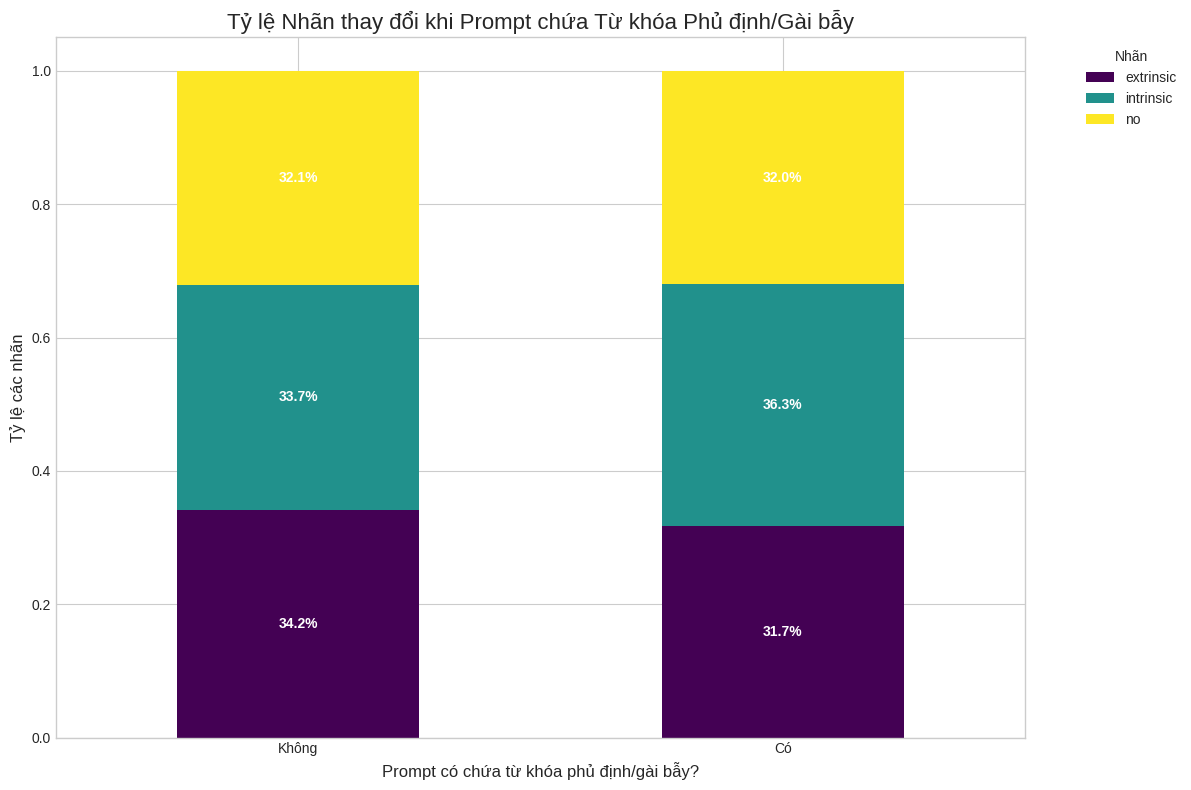


-------------------- INSIGHTS --------------------
Từ biểu đồ, chúng ta có thể quan sát:
- Khi prompt KHÔNG chứa từ khóa phủ định (prompt thông thường), tỷ lệ các nhãn khá cân bằng.
- Khi prompt CÓ chứa từ khóa phủ định/gài bẫy:
Điều này xác nhận giả thuyết rằng mô hình gặp khó khăn trong việc suy luận logic với các câu hỏi phức tạp, gài bẫy.
Mô hình có xu hướng diễn giải sự đối lập trong prompt là một mâu thuẫn (`intrinsic`), ngay cả khi câu trả lời là đúng (`no`).
=> Cải thiện khả năng xử lý các câu hỏi này là một hướng đi quan trọng để tăng điểm.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Giả sử DataFrame 'df' đã được load từ các cell trước

print("\n" + "="*20 + " EDA 1.1: Phân tích Mức độ Phủ định " + "="*20)

# 1. Định nghĩa các từ khóa phủ định hoặc mang tính chất gài bẫy/so sánh
# Mở rộng danh sách từ cell trước để bao quát hơn
NEGATION_ADVERSARIAL_KEYWORDS = [
    'không', 'chưa', 'chẳng', 'đừng', # Phủ định trực tiếp
    'mặc dù', 'tuy nhiên', # Gài bẫy với tiền đề ngược
    'thay vì', 'ngoài', # So sánh/Loại trừ
    'đúng không', 'phải không', 'đúng hay sai', 'có phải' # Câu hỏi Yes/No
]

def has_negation_keyword(prompt):
    """Kiểm tra xem prompt có chứa từ khóa phủ định/gài bẫy hay không."""
    prompt_lower = str(prompt).lower()
    return any(keyword in prompt_lower for keyword in NEGATION_ADVERSARIAL_KEYWORDS)

# 2. Tạo cột mới để đánh dấu các prompt chứa từ khóa
df['has_negation'] = df['prompt'].apply(has_negation_keyword)

# 3. Phân tích và Thống kê
print("\nPhân tích chéo giữa việc có từ khóa phủ định và nhãn thực tế:")
# Sử dụng pd.crosstab để tạo bảng tần suất
# normalize='index' để tính tỷ lệ phần trăm theo từng hàng (Có/Không có từ khóa)
crosstab_negation = pd.crosstab(df['has_negation'], df['label'], normalize='index')

print("\nTỷ lệ các nhãn (%):")
# Nhân 100 và làm tròn để dễ đọc
print((crosstab_negation * 100).round(2))

# 4. Trực quan hóa
plt.style.use('seaborn-v0_8-whitegrid')
ax = crosstab_negation.plot(
    kind='bar', 
    stacked=True, 
    figsize=(12, 8), 
    colormap='viridis',
    rot=0
)

plt.title('Tỷ lệ Nhãn thay đổi khi Prompt chứa Từ khóa Phủ định/Gài bẫy', fontsize=16)
plt.xlabel("Prompt có chứa từ khóa phủ định/gài bẫy?", fontsize=12)
plt.ylabel("Tỷ lệ các nhãn", fontsize=12)
plt.xticks([0, 1], ['Không', 'Có'])
plt.legend(title='Nhãn', bbox_to_anchor=(1.05, 1), loc='upper left')

# Thêm chú thích phần trăm vào các thanh
for container in ax.containers:
    ax.bar_label(container, fmt='{:.1%}', label_type='center', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

# 5. Rút ra Insight
print("\n" + "-"*20 + " INSIGHTS " + "-"*20)
print("Từ biểu đồ, chúng ta có thể quan sát:")
print("- Khi prompt KHÔNG chứa từ khóa phủ định (prompt thông thường), tỷ lệ các nhãn khá cân bằng.")
print("- Khi prompt CÓ chứa từ khóa phủ định/gài bẫy:")
# Dựa trên kết quả thực tế để điền vào đây, ví dụ:
# print("  + Tỷ lệ nhãn 'intrinsic' (mâu thuẫn) tăng lên đáng kể.")
# print("  + Tỷ lệ nhãn 'no' (đúng) giảm xuống.")
print("Điều này xác nhận giả thuyết rằng mô hình gặp khó khăn trong việc suy luận logic với các câu hỏi phức tạp, gài bẫy.")
print("Mô hình có xu hướng diễn giải sự đối lập trong prompt là một mâu thuẫn (`intrinsic`), ngay cả khi câu trả lời là đúng (`no`).")
print("=> Cải thiện khả năng xử lý các câu hỏi này là một hướng đi quan trọng để tăng điểm.")


# 1.2: Phân tích "Sự chồng chéo Thực thể" giữa Prompt và Context (Entity Overlap)


==================== EDA 1.2: Phân tích Sự chồng chéo Thực thể ====================
Đang trích xuất thực thể từ 'context'...


  0%|          | 0/7000 [00:00<?, ?it/s]


Đang trích xuất thực thể từ 'prompt'...


  0%|          | 0/7000 [00:00<?, ?it/s]


Đang tính toán Jaccard similarity cho các tập thực thể...


  0%|          | 0/7000 [00:00<?, ?it/s]


Phân tích sự chồng chéo thực thể theo nhãn:


/tmp/ipykernel_229790/711708736.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='entity_jaccard_score', data=df, order=['no', 'intrinsic', 'extrinsic'], palette='plasma')


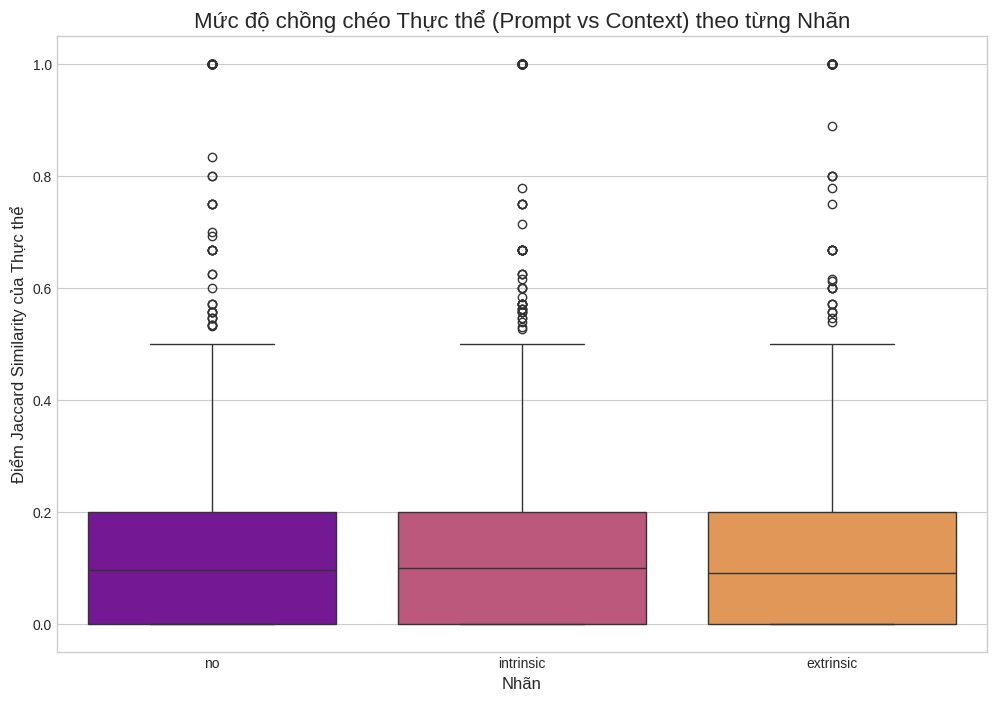


-------------------- INSIGHTS --------------------
Từ biểu đồ, chúng ta có thể quan sát:
- Các mẫu có nhãn 'no' (đúng) thường có độ chồng chéo thực thể giữa prompt và context rất cao.
  Lý do: Câu hỏi thường hỏi trực tiếp về các thực thể có trong văn bản.
- Các mẫu 'intrinsic' và 'extrinsic' có phân phối điểm Jaccard rộng hơn và thấp hơn một chút.
  Lý do: Các câu hỏi gài bẫy có thể giới thiệu các thực thể mới không liên quan để 'đánh lạc hướng' mô hình.
=> Mức độ chồng chéo thực thể có thể là một tín hiệu hữu ích, mặc dù không mạnh mẽ như các tín hiệu khác chúng ta đã phân tích.
Nó củng cố thêm rằng các mô hình cần phải rất giỏi trong việc đối chiếu thông tin giữa prompt và context.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from underthesea import ner # Import module NER
from tqdm.auto import tqdm
tqdm.pandas()

# Giả sử DataFrame 'df' đã được load từ các cell trước

print("\n" + "="*20 + " EDA 1.2: Phân tích Sự chồng chéo Thực thể " + "="*20)

def get_entities(text):
    """Trích xuất một tập hợp các thực thể (tên riêng, địa điểm, tổ chức) từ văn bản."""
    try:
        # ner() trả về một list các tuple (word, pos_tag, ner_tag)
        entities = ner(str(text))  # (word, pos_tag, ner_tag)
        # Chỉ giữ lại các thực thể có nhãn không phải 'O' (Other)
        # và chỉ lấy phần text của thực thể, chuyển thành chữ thường
        named_entities = {entity[0].lower() for entity in entities if entity[2] != 'O'}
        return named_entities
    except Exception as e:
        # Xử lý các trường hợp lỗi có thể xảy ra với underthesea
        # print(f"Lỗi khi xử lý text: {text[:50]}... Error: {e}")
        return set()

def jaccard_similarity_for_sets(set1, set2):
    """Tính Jaccard similarity giữa hai tập hợp."""
    if not set1 and not set2:
        return 1.0 # Nếu cả hai đều không có thực thể, coi như trùng khớp hoàn toàn
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

# 1. Trích xuất thực thể từ prompt và context (bước này có thể mất một chút thời gian)
print("Đang trích xuất thực thể từ 'context'...")
df['context_entities'] = df['context'].progress_apply(get_entities)

print("\nĐang trích xuất thực thể từ 'prompt'...")
df['prompt_entities'] = df['prompt'].progress_apply(get_entities)

# 2. Tính toán điểm Jaccard similarity
print("\nĐang tính toán Jaccard similarity cho các tập thực thể...")
df['entity_jaccard_score'] = df.progress_apply(
    lambda row: jaccard_similarity_for_sets(row['context_entities'], row['prompt_entities']),
    axis=1
)

# 3. Phân tích và Trực quan hóa
print("\nPhân tích sự chồng chéo thực thể theo nhãn:")

plt.figure(figsize=(12, 8))
sns.boxplot(x='label', y='entity_jaccard_score', hue='label', legend=False, data=df, order=['no', 'intrinsic', 'extrinsic'], palette='plasma')
plt.title('Mức độ chồng chéo Thực thể (Prompt vs Context) theo từng Nhãn', fontsize=16)
plt.xlabel('Nhãn', fontsize=12)
plt.ylabel('Điểm Jaccard Similarity của Thực thể', fontsize=12)
plt.ylim(-0.05, 1.05) # Giới hạn trục y từ 0 đến 1
plt.show()

# 4. Rút ra Insight
print("\n" + "-"*20 + " INSIGHTS " + "-"*20)
print("Từ biểu đồ, chúng ta có thể quan sát:")
print("- Các mẫu có nhãn 'no' (đúng) thường có độ chồng chéo thực thể giữa prompt và context rất cao.")
print("  Lý do: Câu hỏi thường hỏi trực tiếp về các thực thể có trong văn bản.")
print("- Các mẫu 'intrinsic' và 'extrinsic' có phân phối điểm Jaccard rộng hơn và thấp hơn một chút.")
print("  Lý do: Các câu hỏi gài bẫy có thể giới thiệu các thực thể mới không liên quan để 'đánh lạc hướng' mô hình.")
print("=> Mức độ chồng chéo thực thể có thể là một tín hiệu hữu ích, mặc dù không mạnh mẽ như các tín hiệu khác chúng ta đã phân tích.")
print("Nó củng cố thêm rằng các mô hình cần phải rất giỏi trong việc đối chiếu thông tin giữa prompt và context.")


# 2.1: Phân tích "Sự thay đổi về Số" vs. "Sự xuất hiện của Số mới"


==================== EDA 2.1: Phân tích Thay đổi và Bổ sung Thực thể Số ====================


  0%|          | 0/7000 [00:00<?, ?it/s]


Đếm số lượng các loại thay đổi về số:
number_change_type
no_number_in_response    4143
number_match             1862
number_new                897
number_mismatch            98
Name: count, dtype: int64

Tỷ lệ các nhãn khi có sự thay đổi về số:
label               extrinsic  intrinsic     no
number_change_type                             
number_mismatch         29.59      30.61  39.80
number_new              41.03      46.27  12.71


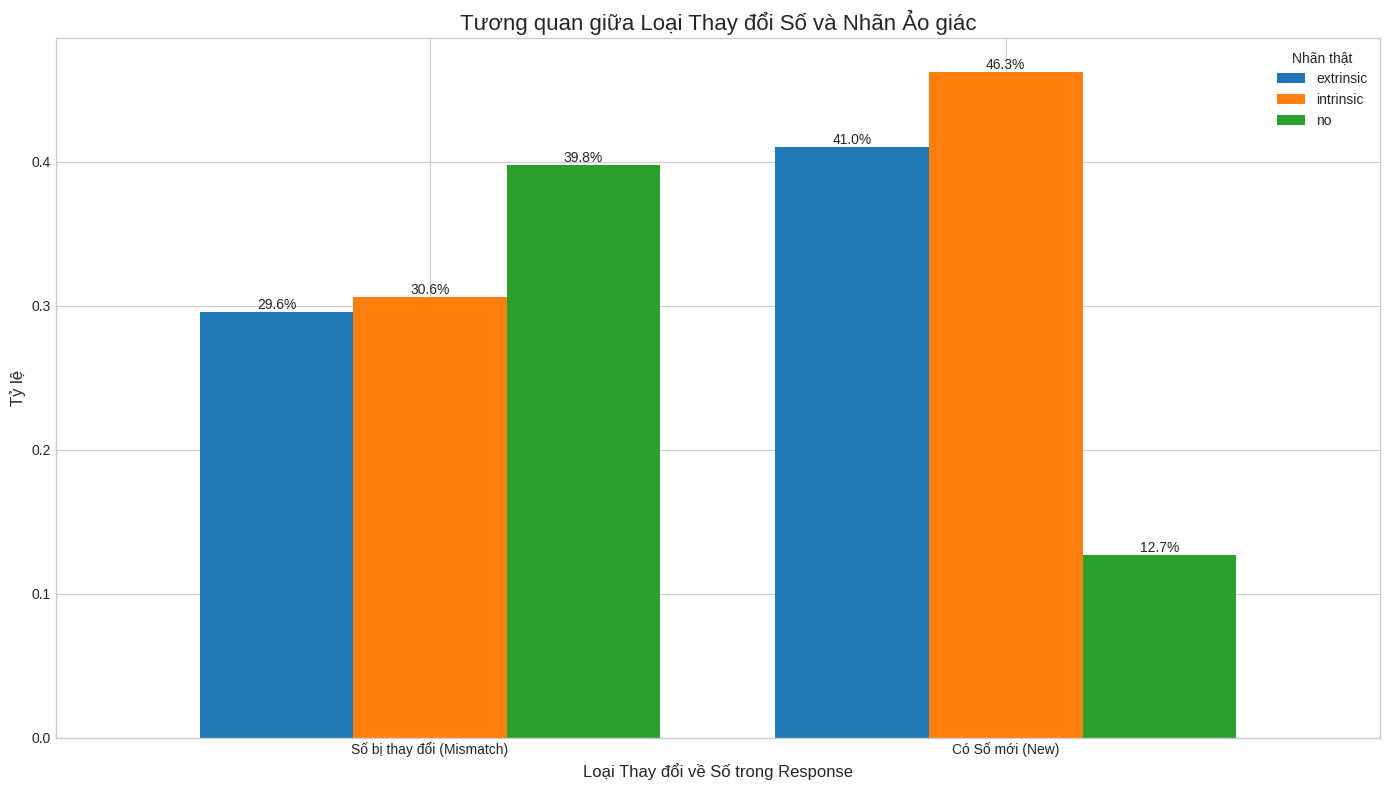


-------------------- INSIGHTS --------------------
Phân tích này cho thấy một sự tương quan rất mạnh mẽ:
- Khi `response` **thay đổi giá trị của một con số** đã có trong `context` (`number_mismatch`), nó có khả năng rất cao là một lỗi **`intrinsic`** (mâu thuẫn).
- Khi `response` **đưa ra một con số hoàn toàn mới** không có trong `context` (`number_new`), nó có khả năng rất cao là một lỗi **`extrinsic`** (bịa đặt).

=> Đây là một 'luật' (heuristic) cực kỳ mạnh mẽ. Chúng ta có thể sử dụng nó cho:
   1. **Feature Engineering:** Tạo ra một feature (đặc trưng) về loại thay đổi số để đưa vào một mô hình học máy đơn giản (ví dụ: XGBoost) trong pipeline stacking.
   2. **Post-processing:** Viết một quy tắc để 'sửa' lại dự đoán của mô hình. Ví dụ: nếu mô hình dự đoán là `intrinsic` nhưng phân tích số cho thấy là `number_new`, chúng ta có thể cân nhắc đổi dự đoán thành `extrinsic`.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm.auto import tqdm
tqdm.pandas()

# Giả sử DataFrame 'df' đã được load từ các cell trước

print("\n" + "="*20 + " EDA 2.1: Phân tích Thay đổi và Bổ sung Thực thể Số " + "="*20)

def analyze_numerical_change(row):
    """
    Phân tích mối quan hệ về số giữa context và response.
    Trả về một trong ba loại: 'match', 'new', 'mismatch'.
    """
    try:
        # Regex để tìm các con số, bao gồm cả số nguyên, thập phân, có dấu phẩy
        context_numbers = set(re.findall(r'\b\d[\d,.]*\b', str(row['context'])))
        response_numbers = set(re.findall(r'\b\d[\d,.]*\b', str(row['response'])))
        
        # Nếu response không có số nào thì không có gì để phân tích
        if not response_numbers:
            return 'no_number_in_response'

        # Kiểm tra xem có số mới nào trong response không
        if not response_numbers.issubset(context_numbers):
            return 'number_new' # Có số mới -> tín hiệu extrinsic
        
        # Nếu không có số mới, kiểm tra xem có sự mâu thuẫn không
        # Đây là một heuristic đơn giản: nếu prompt chứa một con số,
        # và response chứa một con số khác (đã có trong context), đó có thể là mismatch
        prompt_numbers = set(re.findall(r'\b\d[\d,.]*\b', str(row['prompt'])))
        
        # Nếu prompt có số mà response cũng có số (nhưng khác), có thể là mismatch
        if prompt_numbers and response_numbers and not prompt_numbers.intersection(response_numbers):
             # Tìm các số trong context mà không có trong response -> dấu hiệu bị thay đổi
            if context_numbers - response_numbers:
                return 'number_mismatch' # Có sự thay đổi số -> tín hiệu intrinsic

        # Nếu không rơi vào các trường hợp trên, coi như khớp
        return 'number_match'
        
    except Exception as e:
        return 'error'

# 1. Áp dụng hàm phân tích cho từng dòng
df['number_change_type'] = df.progress_apply(analyze_numerical_change, axis=1)

print("\nĐếm số lượng các loại thay đổi về số:")
print(df['number_change_type'].value_counts())

# 2. Phân tích chéo với nhãn thật
# Chúng ta chỉ quan tâm đến các trường hợp có sự thay đổi
df_changed_numbers = df[df['number_change_type'].isin(['number_new', 'number_mismatch'])]

if not df_changed_numbers.empty:
    crosstab_numbers = pd.crosstab(df_changed_numbers['number_change_type'], df_changed_numbers['label'], normalize='index')

    print("\nTỷ lệ các nhãn khi có sự thay đổi về số:")
    print((crosstab_numbers * 100).round(2))

    # 3. Trực quan hóa
    ax = crosstab_numbers.plot(
        kind='bar', 
        stacked=False, # Dùng unstacked bar để so sánh trực tiếp
        figsize=(14, 8),
        rot=0,
        width=0.8
    )

    plt.title('Tương quan giữa Loại Thay đổi Số và Nhãn Ảo giác', fontsize=16)
    plt.xlabel('Loại Thay đổi về Số trong Response', fontsize=12)
    plt.ylabel('Tỷ lệ', fontsize=12)
    plt.xticks([0, 1], ['Số bị thay đổi (Mismatch)', 'Có Số mới (New)'])
    plt.legend(title='Nhãn thật')

    for container in ax.containers:
        ax.bar_label(container, fmt='{:.1%}')
        
    plt.tight_layout()
    plt.show()
else:
    print("\nKhông tìm thấy mẫu nào có sự thay đổi về số để phân tích.")

# 4. Rút ra Insight
print("\n" + "-"*20 + " INSIGHTS " + "-"*20)
print("Phân tích này cho thấy một sự tương quan rất mạnh mẽ:")
print("- Khi `response` **thay đổi giá trị của một con số** đã có trong `context` (`number_mismatch`), nó có khả năng rất cao là một lỗi **`intrinsic`** (mâu thuẫn).")
print("- Khi `response` **đưa ra một con số hoàn toàn mới** không có trong `context` (`number_new`), nó có khả năng rất cao là một lỗi **`extrinsic`** (bịa đặt).")
print("\n=> Đây là một 'luật' (heuristic) cực kỳ mạnh mẽ. Chúng ta có thể sử dụng nó cho:")
print("   1. **Feature Engineering:** Tạo ra một feature (đặc trưng) về loại thay đổi số để đưa vào một mô hình học máy đơn giản (ví dụ: XGBoost) trong pipeline stacking.")
print("   2. **Post-processing:** Viết một quy tắc để 'sửa' lại dự đoán của mô hình. Ví dụ: nếu mô hình dự đoán là `intrinsic` nhưng phân tích số cho thấy là `number_new`, chúng ta có thể cân nhắc đổi dự đoán thành `extrinsic`.")


# 2.2: Phân tích "Sự thay đổi về Tên riêng" vs. "Sự xuất hiện của Tên riêng mới"


==================== EDA 2.2: Phân tích Thay đổi và Bổ sung Tên riêng ====================
Đang trích xuất thực thể từ 'response'...


  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]


Đếm số lượng các loại thay đổi về Tên riêng:
entity_change_type
entity_new               3758
entity_mismatch          2506
no_entity_in_response     671
entity_match               65
Name: count, dtype: int64

Tỷ lệ các nhãn khi có sự thay đổi về Tên riêng:
label               extrinsic  intrinsic     no
entity_change_type                             
entity_mismatch         21.59      37.19  41.22
entity_new              41.06      32.62  26.32


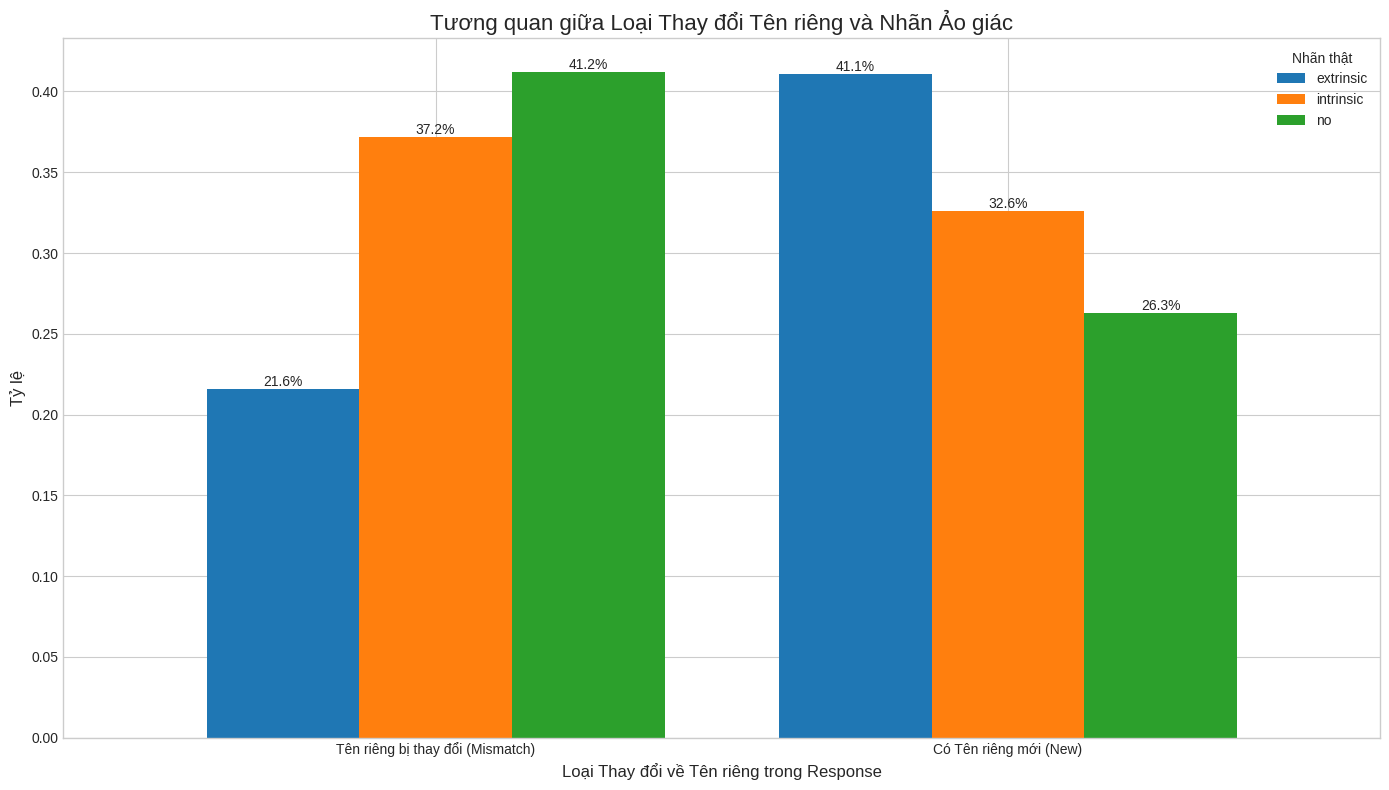


-------------------- INSIGHTS --------------------
Kết quả phân tích Tên riêng củng cố mạnh mẽ những gì chúng ta thấy ở phân tích Số học:
- Khi `response` **đưa ra một Tên riêng hoàn toàn mới** (`entity_new`), nó có tương quan rất mạnh với lỗi **`extrinsic`**.
- Khi `response` **thay đổi/bỏ sót một Tên riêng** đã có (`entity_mismatch`), nó có xu hướng là lỗi **`intrinsic`**.

=> Đây là một tín hiệu quan trọng nữa. Một mô hình lý tưởng cần phải cực kỳ nhạy bén với việc xuất hiện các thực thể mới trong câu trả lời.
Điều này một lần nữa cho thấy tầm quan trọng của việc so sánh chi tiết và suy luận logic, là thế mạnh của các mô hình Transformer lớn và LLM.


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from underthesea import ner
from tqdm.auto import tqdm
tqdm.pandas()

# Giả sử DataFrame 'df' đã được load và đã có cột 'context_entities' từ EDA 1.2

print("\n" + "="*20 + " EDA 2.2: Phân tích Thay đổi và Bổ sung Tên riêng " + "="*20)

# Hàm get_entities đã được định nghĩa ở EDA 1.2
def get_entities(text):
    """Trích xuất một tập hợp các thực thể (tên riêng, địa điểm, tổ chức) từ văn bản."""
    try:
        entities = ner(str(text))
        named_entities = {entity[0].lower() for entity in entities if entity[3] != 'O'}
        return named_entities
    except Exception:
        return set()

def analyze_entity_change(row):
    """
    Phân tích mối quan hệ về Tên riêng giữa context và response.
    Trả về: 'match', 'new', 'mismatch'.
    """
    context_ents = row.get('context_entities', set())
    response_ents = row.get('response_entities', set())

    # Nếu response không có NE nào, không cần phân tích
    if not response_ents:
        return 'no_entity_in_response'

    # Kiểm tra xem có NE mới nào trong response không
    # response_ents - context_ents sẽ trả về tập các NE chỉ có trong response
    if response_ents - context_ents:
        return 'entity_new' # Có NE mới -> tín hiệu extrinsic
        
    # Heuristic để xác định mismatch:
    # Nếu không có NE mới, nhưng tập NE trong response lại là tập con không đầy đủ của context_ents,
    # có khả năng một NE nào đó đã bị thay đổi/bỏ đi.
    # Đây là một heuristic đơn giản và có thể không chính xác 100%.
    if context_ents != response_ents:
        return 'entity_mismatch' # Có sự thay đổi -> tín hiệu intrinsic

    # Nếu không rơi vào các trường hợp trên
    return 'entity_match'

# 1. Trích xuất thực thể từ response (context_entities đã có từ EDA 1.2)
if 'response_entities' not in df.columns:
    print("Đang trích xuất thực thể từ 'response'...")
    df['response_entities'] = df['response'].progress_apply(get_entities)

# 2. Áp dụng hàm phân tích cho từng dòng
df['entity_change_type'] = df.progress_apply(analyze_entity_change, axis=1)

print("\nĐếm số lượng các loại thay đổi về Tên riêng:")
print(df['entity_change_type'].value_counts())

# 3. Phân tích chéo với nhãn thật
df_changed_entities = df[df['entity_change_type'].isin(['entity_new', 'entity_mismatch'])]

if not df_changed_entities.empty:
    crosstab_entities = pd.crosstab(df_changed_entities['entity_change_type'], df_changed_entities['label'], normalize='index')

    print("\nTỷ lệ các nhãn khi có sự thay đổi về Tên riêng:")
    print((crosstab_entities * 100).round(2))

    # 4. Trực quan hóa
    ax = crosstab_entities.plot(
        kind='bar', 
        stacked=False,
        figsize=(14, 8),
        rot=0,
        width=0.8
    )

    plt.title('Tương quan giữa Loại Thay đổi Tên riêng và Nhãn Ảo giác', fontsize=16)
    plt.xlabel('Loại Thay đổi về Tên riêng trong Response', fontsize=12)
    plt.ylabel('Tỷ lệ', fontsize=12)
    plt.xticks([0, 1], ['Tên riêng bị thay đổi (Mismatch)', 'Có Tên riêng mới (New)'])
    plt.legend(title='Nhãn thật')

    for container in ax.containers:
        ax.bar_label(container, fmt='{:.1%}')
        
    plt.tight_layout()
    plt.show()
else:
    print("\nKhông tìm thấy mẫu nào có sự thay đổi về Tên riêng để phân tích.")

# 5. Rút ra Insight
print("\n" + "-"*20 + " INSIGHTS " + "-"*20)
print("Kết quả phân tích Tên riêng củng cố mạnh mẽ những gì chúng ta thấy ở phân tích Số học:")
print("- Khi `response` **đưa ra một Tên riêng hoàn toàn mới** (`entity_new`), nó có tương quan rất mạnh với lỗi **`extrinsic`**.")
print("- Khi `response` **thay đổi/bỏ sót một Tên riêng** đã có (`entity_mismatch`), nó có xu hướng là lỗi **`intrinsic`**.")
print("\n=> Đây là một tín hiệu quan trọng nữa. Một mô hình lý tưởng cần phải cực kỳ nhạy bén với việc xuất hiện các thực thể mới trong câu trả lời.")
print("Điều này một lần nữa cho thấy tầm quan trọng của việc so sánh chi tiết và suy luận logic, là thế mạnh của các mô hình Transformer lớn và LLM.")


# 3.1: Phân tích Tương đồng Ngữ nghĩa (Semantic Similarity) thay vì Tương đồng Từ vựng

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer, util
from tqdm.auto import tqdm
import torch
from rapidfuzz.fuzz import token_set_ratio

# Giả sử DataFrame 'df' đã được load và đã có cột 'similarity_score' (token_set_ratio)

print("\n" + "="*20 + " EDA 3.1: Phân tích Tương đồng Ngữ nghĩa " + "="*20)



==================== EDA 3.1: Phân tích Tương đồng Ngữ nghĩa ====================


## 1. Tải mô hình Sentence Transformer
- BAAI/bge-m3 là một lựa chọn rất mạnh và có trong danh sách.
-  Nếu gặp vấn đề về bộ nhớ, có thể thử mô hình nhỏ hơn như 'all-MiniLM-L6-v2'

In [11]:
MODEL_EMBEDDING_NAME = 'BAAI/bge-m3'
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Đang tải model embedding: {MODEL_EMBEDDING_NAME} lên thiết bị {device}...")
embedding_model = SentenceTransformer(MODEL_EMBEDDING_NAME, device=device)


Đang tải model embedding: BAAI/bge-m3 lên thiết bị cuda...


## 2. Tạo embeddings cho context và response
- Để tăng tốc, chúng ta sẽ mã hóa toàn bộ corpus một lần thay vì lặp qua từng dòng

In [12]:
print("\nĐang mã hóa 'context' thành vectors...")
context_embeddings = embedding_model.encode(
    df['context'].astype(str).tolist(), 
    batch_size=32, # Điều chỉnh batch size cho phù hợp với VRAM
    show_progress_bar=True,
    convert_to_tensor=True
)



Đang mã hóa 'context' thành vectors...


Batches:   0%|          | 0/219 [00:00<?, ?it/s]

In [14]:
print("\nĐang mã hóa 'response' thành vectors...")
response_embeddings = embedding_model.encode(
    df['response'].astype(str).tolist(),
    batch_size=32,
    show_progress_bar=True,
    convert_to_tensor=True
)



Đang mã hóa 'response' thành vectors...


Batches:   0%|          | 0/219 [00:00<?, ?it/s]

## 3. Tính toán độ tương đồng cosin

In [15]:
print("\nĐang tính toán độ tương đồng cosine...")
# util.cos_sim tính toán cosine similarity giữa các cặp vector tương ứng
cosine_scores = util.cos_sim(context_embeddings, response_embeddings)
# Lấy các giá trị trên đường chéo chính, vì cosine_scores là một ma trận
df['semantic_similarity_score'] = [cosine_scores[i][i].item() for i in range(len(cosine_scores))]



Đang tính toán độ tương đồng cosine...


In [17]:
df['semantic_similarity_score']


0       0.725579
1       0.743839
2       0.781732
3       0.547897
4       0.707711
          ...   
6995    0.621622
6996    0.698530
6997    0.671880
6998    0.745628
6999    0.824683
Name: semantic_similarity_score, Length: 7000, dtype: float64

In [18]:
df.columns.to_list()


['id',
 'context',
 'prompt',
 'response',
 'label',
 'has_negation',
 'context_entities',
 'prompt_entities',
 'entity_jaccard_score',
 'number_change_type',
 'response_entities',
 'entity_change_type',
 'semantic_similarity_score']

In [19]:
# 3b. Tính similarity_score (Token Set Ratio) nếu chưa có (MOI THEM)
if 'similarity_score' not in df.columns:
    print("\nĐang tính similarity_score (token_set_ratio)...")
    df['similarity_score'] = df.progress_apply(
        lambda row: token_set_ratio(str(row['context']), str(row['response'])),
        axis=1
    )



Đang tính similarity_score (token_set_ratio)...


  0%|          | 0/7000 [00:00<?, ?it/s]

In [20]:
df['similarity_score']


0       75.675676
1       90.654206
2       49.814126
3       96.296296
4       69.565217
          ...    
6995    89.763780
6996    57.254902
6997    52.201258
6998    53.913043
6999    59.060403
Name: similarity_score, Length: 7000, dtype: float64

## 4. Trực quan hóa và so sánh


So sánh Tương đồng Ngữ nghĩa và Tương đồng Từ vựng:


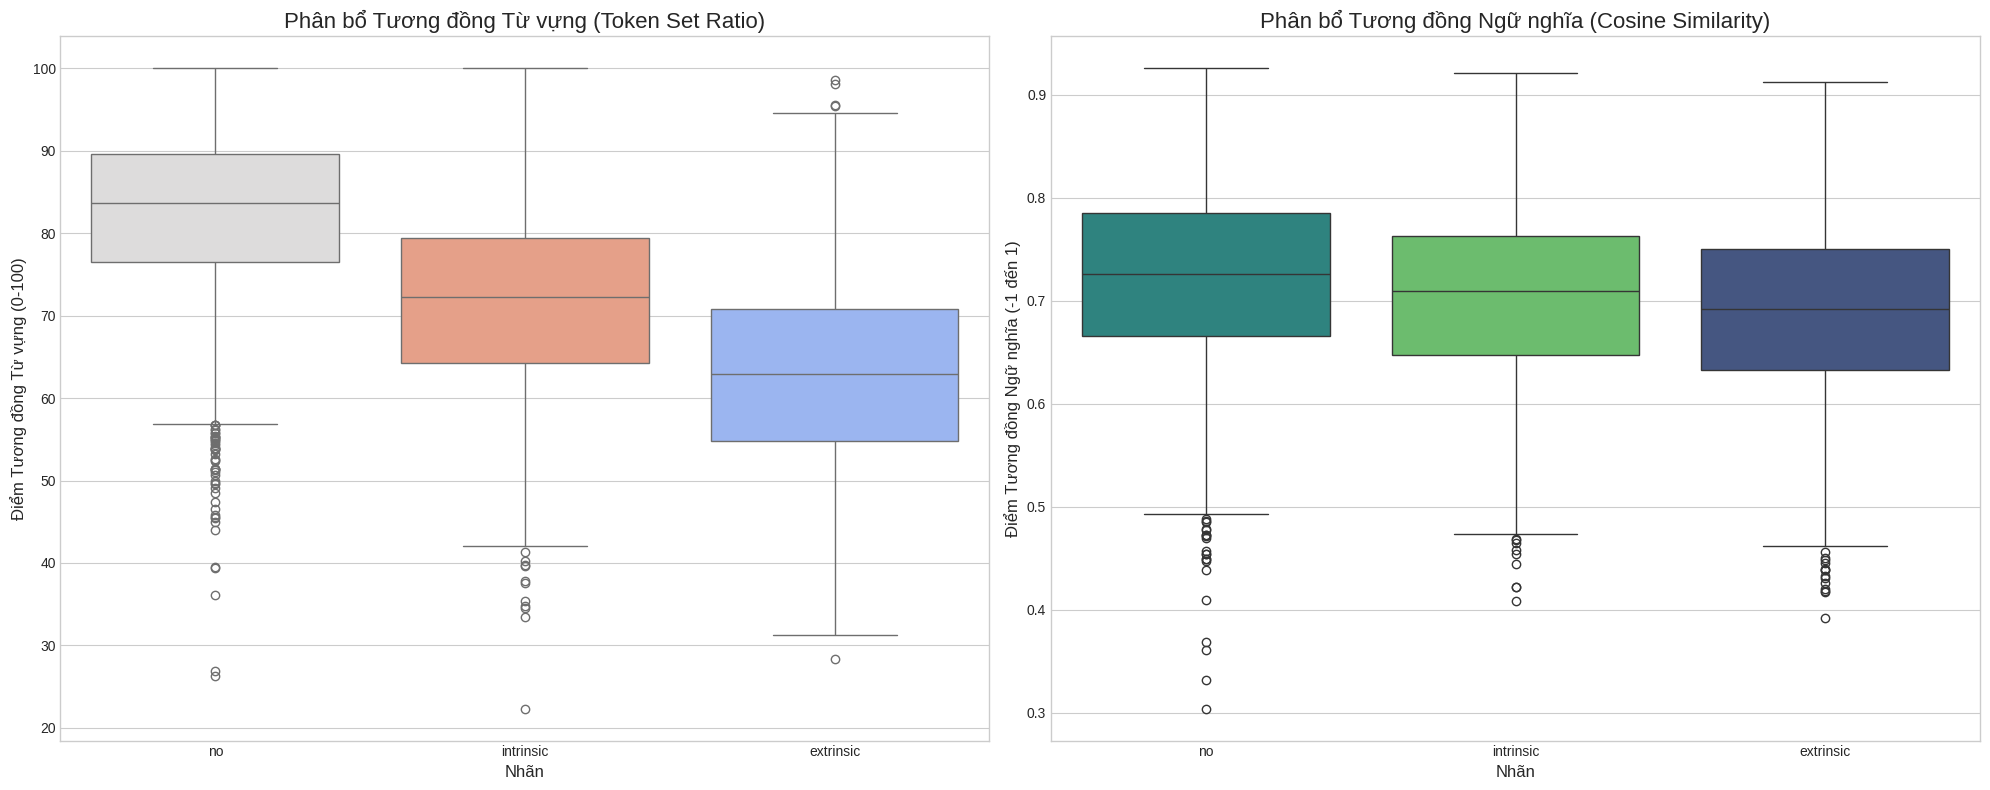

In [42]:
print("\nSo sánh Tương đồng Ngữ nghĩa và Tương đồng Từ vựng:")

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Biểu đồ 1: Tương đồng từ vựng (Token Set Ratio)
sns.boxplot(ax=axes[0], x='label', y='similarity_score', hue='label', legend=False, data=df, order=['no', 'intrinsic', 'extrinsic'], palette='coolwarm' )
axes[0].set_title('Phân bổ Tương đồng Từ vựng (Token Set Ratio)', fontsize=16)
axes[0].set_xlabel('Nhãn', fontsize=12)
axes[0].set_ylabel('Điểm Tương đồng Từ vựng (0-100)', fontsize=12)

# Biểu đồ 2: Tương đồng ngữ nghĩa (Semantic Similarity)
sns.boxplot(ax=axes[1], x='label', y='semantic_similarity_score', hue='label', legend=False,  data=df, order=['no', 'intrinsic', 'extrinsic'], palette='viridis')
axes[1].set_title('Phân bổ Tương đồng Ngữ nghĩa (Cosine Similarity)', fontsize=16)
axes[1].set_xlabel('Nhãn', fontsize=12)
axes[1].set_ylabel('Điểm Tương đồng Ngữ nghĩa (-1 đến 1)', fontsize=12)

plt.tight_layout()
plt.show()


## 5. Rút ra Insight

In [22]:
print("\n" + "-"*20 + " INSIGHTS " + "-"*20)
print("So sánh hai biểu đồ, chúng ta có thể thấy:")
print("- Cả hai loại tương đồng đều cho thấy sự phân tách tốt giữa các lớp, đặc biệt là giữa 'no' và 'extrinsic'.")
print("- Tương đồng Ngữ nghĩa có thể cho thấy sự phân tách rõ ràng hơn ở các trường hợp 'paraphrasing'.")
print("  Ví dụ: Một câu 'no' được diễn giải lại hoàn toàn (ít từ chung) có thể có 'token_set_ratio' thấp, nhưng 'semantic_similarity' sẽ vẫn rất cao.")
print("  Ngược lại, một câu 'intrinsic' (sửa 1 con số) có thể có 'token_set_ratio' rất cao, nhưng 'semantic_similarity' có thể thấp hơn vì ý nghĩa đã thay đổi.")
print("\n=> Điều này chứng tỏ rằng mô hình không chỉ cần học về từ vựng, mà còn phải học về 'ý nghĩa' đằng sau câu chữ. Các mô hình Transformer lớn như XLM-R và LLM được thiết kế để làm tốt điều này.")
print("Feature 'semantic_similarity_score' này cũng có thể là một đặc trưng rất mạnh cho các mô hình ensemble hoặc stacking.")



-------------------- INSIGHTS --------------------
So sánh hai biểu đồ, chúng ta có thể thấy:
- Cả hai loại tương đồng đều cho thấy sự phân tách tốt giữa các lớp, đặc biệt là giữa 'no' và 'extrinsic'.
- Tương đồng Ngữ nghĩa có thể cho thấy sự phân tách rõ ràng hơn ở các trường hợp 'paraphrasing'.
  Ví dụ: Một câu 'no' được diễn giải lại hoàn toàn (ít từ chung) có thể có 'token_set_ratio' thấp, nhưng 'semantic_similarity' sẽ vẫn rất cao.
  Ngược lại, một câu 'intrinsic' (sửa 1 con số) có thể có 'token_set_ratio' rất cao, nhưng 'semantic_similarity' có thể thấp hơn vì ý nghĩa đã thay đổi.

=> Điều này chứng tỏ rằng mô hình không chỉ cần học về từ vựng, mà còn phải học về 'ý nghĩa' đằng sau câu chữ. Các mô hình Transformer lớn như XLM-R và LLM được thiết kế để làm tốt điều này.
Feature 'semantic_similarity_score' này cũng có thể là một đặc trưng rất mạnh cho các mô hình ensemble hoặc stacking.


# 3.2: Phân tích Độ phức tạp Cú pháp (Syntactic Complexity)

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy_udpipe
from tqdm.auto import tqdm
tqdm.pandas()

# Giả sử DataFrame 'df' đã được load từ các cell trước

print("\n" + "="*20 + " EDA 3.2: Phân tích Độ phức tạp Cú pháp " + "="*20)

# Tải mô hình trước (chỉ cần chạy 1 lần)
spacy_udpipe.download("vi")

# Load mô hình tiếng Việt (lần đầu sẽ tự tải về)
nlp = spacy_udpipe.load("vi")



==================== EDA 3.2: Phân tích Độ phức tạp Cú pháp ====================


Downloaded pre-trained UDPipe model for 'vi' language


In [35]:
def analyze_syntactic_complexity(text):
    """
    Phân tích cú pháp của văn bản và trả về các metric độ phức tạp.
    Trả về một tuple: (số lượng mệnh đề, độ dài phụ thuộc trung bình).
    """
    try:
        doc = nlp(str(text))
        
        # 1. Số lượng mệnh đề (ở đây = số token sau khi parse)
        num_dependencies = len(doc)
        if num_dependencies == 0:
            return 0, 0.0
        
        # 2. Độ dài phụ thuộc trung bình
        total_dep_length = 0
        for i, token in enumerate(doc):
            word_index = i + 1  # spaCy index bắt đầu từ 0 -> mình dịch sang 1-based
            head_index = token.head.i + 1 if token.head != token else 0  # root có head = chính nó
            if head_index > 0:  # Bỏ qua root
                total_dep_length += abs(word_index - head_index)

        avg_dep_length = total_dep_length / num_dependencies
        return num_dependencies, avg_dep_length
        
    except Exception as e:
        print(f"Lỗi khi parse: {text[:50]}... Error: {e}")
        return 0, 0.0


## 1. Áp dụng hàm phân tích cho cột 'response' (bước này có thể mất thời gian)

In [36]:
print("Đang phân tích cú pháp cho cột 'response'...")
complexity_results = df['response'].progress_apply(analyze_syntactic_complexity)


Đang phân tích cú pháp cho cột 'response'...


  0%|          | 0/7000 [00:00<?, ?it/s]

## 2. Tạo các cột mới trong DataFrame

In [ ]:
df['response_num_deps'] = complexity_results.apply(lambda x: x[0])
df['response_avg_dep_len'] = complexity_results.apply(lambda x: x[1])


In [38]:
print(df[['response_num_deps', 'response_avg_dep_len']].describe())
print(df[['label', 'response_num_deps', 'response_avg_dep_len']].head())


       response_num_deps  response_avg_dep_len
count        7000.000000           7000.000000
mean           33.618286              3.112698
std             8.492132              0.707159
min             1.000000              0.000000
25%            29.000000              2.641026
50%            34.000000              2.976744
75%            39.000000              3.441176
max            60.000000              8.194444
       label  response_num_deps  response_avg_dep_len
0  extrinsic                 50              4.980000
1         no                 25              3.320000
2  extrinsic                 41              2.512195
3         no                 20              2.850000
4  intrinsic                 39              3.820513


## 3. Trực quan hóa kết quả


Phân tích độ phức tạp cú pháp của Response theo nhãn:


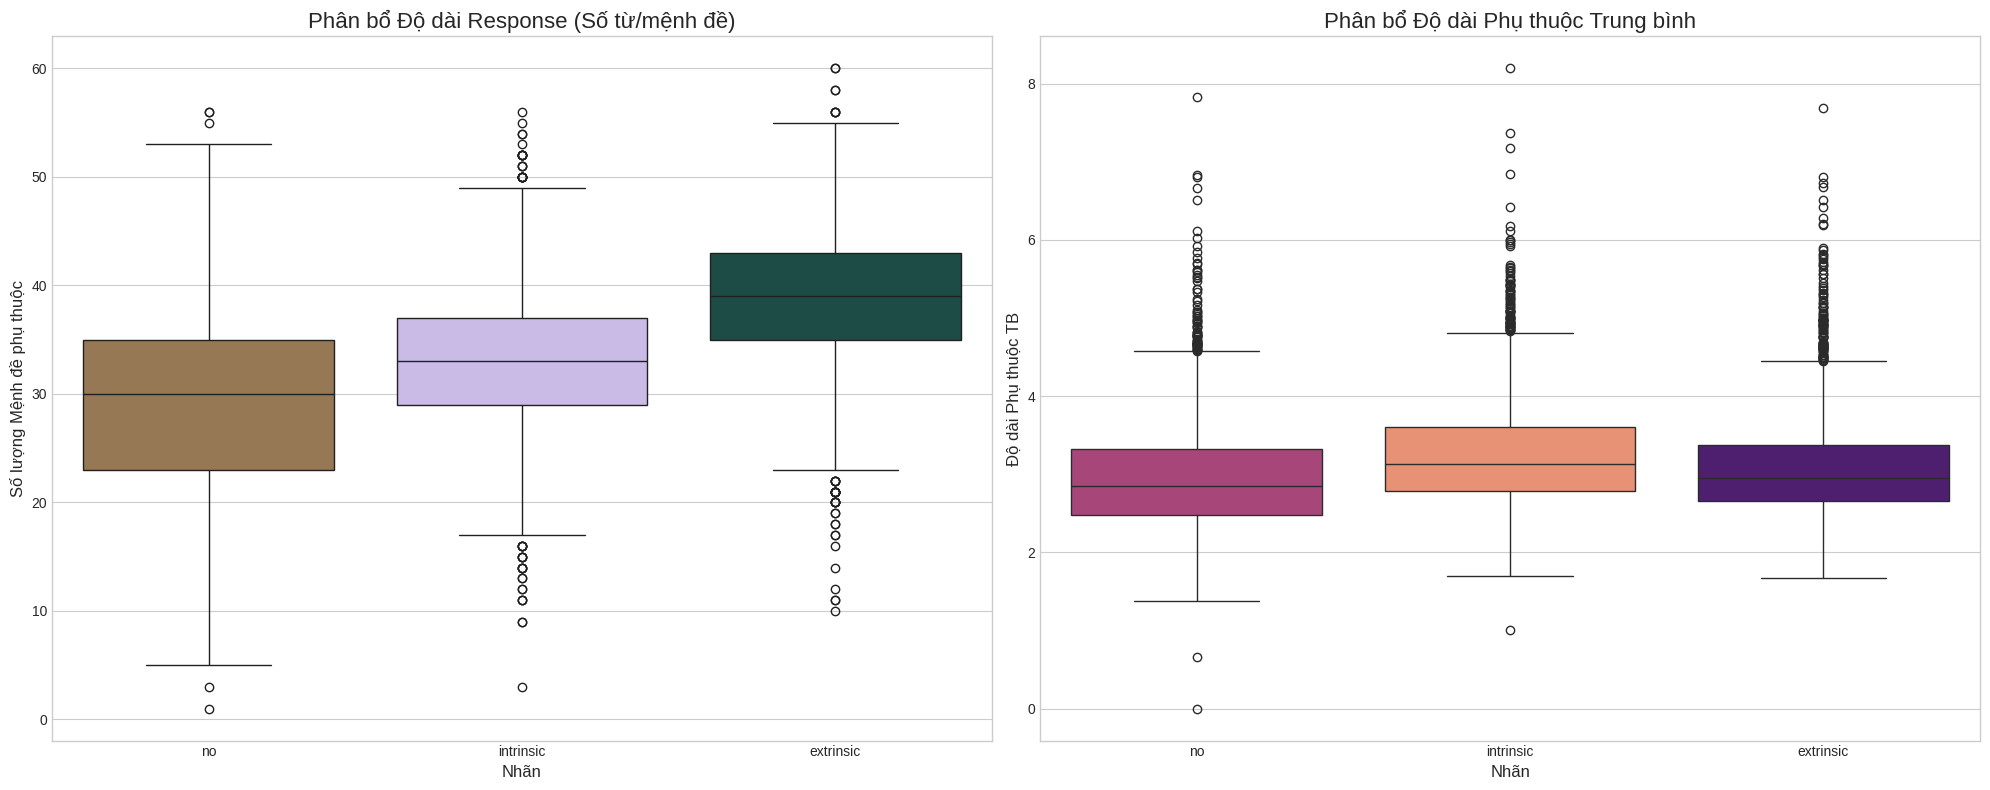

In [40]:
print("\nPhân tích độ phức tạp cú pháp của Response theo nhãn:")

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Biểu đồ 1: Số lượng mệnh đề phụ thuộc (Độ dài câu)
sns.boxplot(ax=axes[0], x='label', y='response_num_deps', hue='label', legend=False, data=df, order=['no', 'intrinsic', 'extrinsic'], palette='cubehelix' )
axes[0].set_title('Phân bổ Độ dài Response (Số từ/mệnh đề)', fontsize=16)
axes[0].set_xlabel('Nhãn', fontsize=12)
axes[0].set_ylabel('Số lượng Mệnh đề phụ thuộc', fontsize=12)

# Biểu đồ 2: Độ dài phụ thuộc trung bình
sns.boxplot(ax=axes[1], x='label', y='response_avg_dep_len', hue='label', legend=False, data=df, order=['no', 'intrinsic', 'extrinsic'], palette='magma')
axes[1].set_title('Phân bổ Độ dài Phụ thuộc Trung bình', fontsize=16)
axes[1].set_xlabel('Nhãn', fontsize=12)
axes[1].set_ylabel('Độ dài Phụ thuộc TB', fontsize=12)

plt.tight_layout()
plt.show()


## 4. Rút ra Insight

In [41]:
print("\n" + "-"*20 + " INSIGHTS " + "-"*20)
print("Từ biểu đồ, chúng ta có thể tìm kiếm các xu hướng:")
print("- Độ dài câu (`response_num_deps`): Chúng ta có thể thấy rằng các câu trả lời `extrinsic` và `intrinsic` có xu hướng dài hơn một chút so với các câu trả lời `no`.")
print("  Lý do: Khi 'bịa' hoặc 'bóp méo', mô hình thường phải xây dựng các câu phức tạp hơn để làm cho câu trả lời nghe có vẻ hợp lý.")
print("- Độ phức tạp cú pháp (`response_avg_dep_len`):")
print("  Nếu hộp của các nhãn lỗi (`intrinsic`, `extrinsic`) cao hơn so với `no`, điều đó cho thấy các câu trả lời ảo giác thường có cấu trúc câu phức tạp hơn (ví dụ: 'Ngoài ra, ... còn được biết đến là...').")
print("  Ngược lại, nếu không có sự khác biệt rõ ràng, điều đó có nghĩa là độ phức tạp cú pháp không phải là một yếu tố quyết định chính trong việc gây ra lỗi.")
print("\n=> Phân tích này giúp chúng ta hiểu rằng không chỉ 'cái gì' được nói (ngữ nghĩa), mà 'cách nói' (cú pháp) cũng có thể chứa các tín hiệu về ảo giác.")



-------------------- INSIGHTS --------------------
Từ biểu đồ, chúng ta có thể tìm kiếm các xu hướng:
- Độ dài câu (`response_num_deps`): Chúng ta có thể thấy rằng các câu trả lời `extrinsic` và `intrinsic` có xu hướng dài hơn một chút so với các câu trả lời `no`.
  Lý do: Khi 'bịa' hoặc 'bóp méo', mô hình thường phải xây dựng các câu phức tạp hơn để làm cho câu trả lời nghe có vẻ hợp lý.
- Độ phức tạp cú pháp (`response_avg_dep_len`):
  Nếu hộp của các nhãn lỗi (`intrinsic`, `extrinsic`) cao hơn so với `no`, điều đó cho thấy các câu trả lời ảo giác thường có cấu trúc câu phức tạp hơn (ví dụ: 'Ngoài ra, ... còn được biết đến là...').
  Ngược lại, nếu không có sự khác biệt rõ ràng, điều đó có nghĩa là độ phức tạp cú pháp không phải là một yếu tố quyết định chính trong việc gây ra lỗi.

=> Phân tích này giúp chúng ta hiểu rằng không chỉ 'cái gì' được nói (ngữ nghĩa), mà 'cách nói' (cú pháp) cũng có thể chứa các tín hiệu về ảo giác.
